In [16]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.utils import resample

warnings.filterwarnings('ignore')




In [2]:
filepath='data.xlsx'
df = pd.read_excel(filepath)
print(len(df))
df.head()

1226


,Unnamed: 0,topic_id,forum_type,raw,user_id,created_at,topic_name,url,like_count,reply_count,reads,word_count,posts_count,num_words
0,0,24233,Ask a Therapist,my finance feels that i don t love her and tha...,17609,2025-06-06 00:58:09.881,emotionless,https://letstalk.mindline.sg/t/emotionless/24233,0,0,5,1463,2,893
1,1,24232,Ask a Therapist,hi i would like some advice on this current si...,19287,2025-06-06 00:55:29.411,how-do-i-better-cope-with-my-negative-thoughts,https://letstalk.mindline.sg/t/how-do-i-better...,0,0,6,972,2,570
2,2,24226,Ask a Therapist,i wonder how many people actually ends up star...,15871,2025-06-05 10:14:12.128,is-it-normal-for-hobby-turned-obsession,https://letstalk.mindline.sg/t/is-it-normal-fo...,0,2,37,887,5,121
3,3,24220,Ask a Therapist,i liked a girl she nv give a clear response to...,19278,2025-06-05 01:16:39.404,hope-to-cope,https://letstalk.mindline.sg/t/hope-to-cope/24220,0,0,12,271,2,21
4,4,24210,Ask a Therapist,for some reason i keep waking up at am in the ...,19274,2025-06-04 10:45:24.356,cant-get-enough-sleep,https://letstalk.mindline.sg/t/cant-get-enough...,0,0,23,709,3,67


In [9]:


file_path = "data.xlsx"   # or your actual path
df = pd.read_excel(file_path, sheet_name="aat_first_topic")

df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")

# Create a 'month' column for grouping
df["month"] = df["created_at"].dt.to_period("M")

# Agg user activity by user_id and month
monthly = (
    df.groupby(["user_id", "month"])
      .agg(
          posts=("topic_id", "count"),
          replies=("reply_count", "sum"),
          likes=("like_count", "sum"),
          reads=("reads", "sum"),
          total_words=("num_words", "sum"),
          last_activity=("created_at", "max"),
          first_activity=("created_at", "min")
      )
      .reset_index()
)

# Sort for time-aware calculation
monthly = monthly.sort_values(["user_id", "month"]).reset_index(drop=True)


# For each user, find their next activity date
monthly["next_activity"] = monthly.groupby("user_id")["last_activity"].shift(-1)

# Compute days between current and next activity
monthly["days_to_next_activity"] = (
    monthly["next_activity"] - monthly["last_activity"]
).dt.days


# Churned in next 30 days if NA or gap > 30
monthly["churned_next_30d"] = np.where(
    monthly["days_to_next_activity"].isna(),  # never came back
    True,                                     # treat as churned
    monthly["days_to_next_activity"] > 30     # also churned if inactive > 30 days
)

# Extract year for aggregation
monthly["snapshot_year"] = monthly["last_activity"].dt.year


churn_counts_by_year = (
    monthly.groupby(["snapshot_year", "churned_next_30d"])
           .size()
           .unstack(fill_value=0)
           .rename(columns={False: "not_churned_next_30d", True: "churned_next_30d"})
)

churn_counts_by_year["total_snapshots"] = churn_counts_by_year.sum(axis=1)
churn_counts_by_year["churn_rate"] = (
    churn_counts_by_year["churned_next_30d"] /
    churn_counts_by_year["total_snapshots"]
)

print("Churn counts by year:")
print(churn_counts_by_year)


Churn counts by year:
churned_next_30d  not_churned_next_30d  churned_next_30d  total_snapshots  \
snapshot_year                                                               
2022                                 2                29               31   
2023                                 5               184              189   
2024                                25               624              649   
2025                                14               243              257   

churned_next_30d  churn_rate  
snapshot_year                 
2022                0.935484  
2023                0.973545  
2024                0.961479  
2025                0.945525  


In [10]:
from IPython.display import HTML, display

def display_scrollable(df, height=400, width="100%", max_rows=None, max_cols=None, show_index=False):
    """
    Render a pandas DataFrame in a scrollable HTML box (Jupyter/Colab).
    
    Args:
        df (pd.DataFrame): Data to display.
        height (int): Box height in pixels.
        width (str): Box width (e.g., '100%', '900px').
        max_rows (int|None): If set, limit rows rendered (None = all).
        max_cols (int|None): If set, limit columns rendered (None = all).
        show_index (bool): Whether to display the index column.
    """
    # Optionally limit size for rendering
    _df = df.copy()
    if max_rows is not None:
        _df = _df.head(max_rows)
    if max_cols is not None and max_cols < len(_df.columns):
        _df = _df.iloc[:, :max_cols]

    html = _df.to_html(index=show_index, escape=False)

    # Sticky header + scroll box
    styled = f"""
    <div style="border:1px solid #ddd; border-radius:6px; width:{width}; height:{height}px; overflow:auto;">
      <style>
        .scrollable-table table {{
          border-collapse: collapse;
          width: 100%;
        }}
        .scrollable-table th, .scrollable-table td {{
          border: 1px solid #eee;
          padding: 6px 8px;
          text-align: left;
          white-space: nowrap;
        }}
        .scrollable-table thead th {{
          position: sticky;
          top: 0;
          background: #fafafa;
          z-index: 1;
        }}
      </style>
      <div class="scrollable-table">{html}</div>
    </div>
    """
    display(HTML(styled))

In [11]:
display_scrollable(monthly)

user_id,month,posts,replies,likes,reads,total_words,last_activity,first_activity,next_activity,days_to_next_activity,churned_next_30d,snapshot_year
53,2022-06,1,0,0,161,26,2022-06-27 03:32:52.429,2022-06-27 03:32:52.429,2022-07-01 01:05:19.499,3.0,False,2022
53,2022-07,1,1,5,210,60,2022-07-01 01:05:19.499,2022-07-01 01:05:19.499,NaT,NaN,True,2022
64,2022-06,1,0,4,67,191,2022-06-30 04:36:04.695,2022-06-30 04:36:04.695,NaT,NaN,True,2022
82,2022-07,1,0,7,73,88,2022-07-06 05:44:28.220,2022-07-06 05:44:28.220,NaT,NaN,True,2022
86,2022-07,1,0,0,54,7,2022-07-15 03:39:54.844,2022-07-15 03:39:54.844,NaT,NaN,True,2022
87,2022-07,2,5,9,300,184,2022-07-30 00:51:59.867,2022-07-19 02:46:41.652,NaT,NaN,True,2022
94,2022-07,1,0,13,119,77,2022-07-07 09:27:20.858,2022-07-07 09:27:20.858,NaT,NaN,True,2022
97,2022-07,1,0,4,117,35,2022-07-06 05:49:10.735,2022-07-06 05:49:10.735,NaT,NaN,True,2022
99,2022-07,1,0,0,60,6,2022-07-12 01:16:08.000,2022-07-12 01:16:08.000,NaT,NaN,True,2022
101,2022-07,1,4,4,202,21,2022-07-06 05:55:09.104,2022-07-06 05:55:09.104,2022-08-05 09:06:01.054,30.0,False,2022


## Build Model to Predict Churn

In [12]:
monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126 entries, 0 to 1125
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                1126 non-null   int64         
 1   month                  1126 non-null   period[M]     
 2   posts                  1126 non-null   int64         
 3   replies                1126 non-null   int64         
 4   likes                  1126 non-null   int64         
 5   reads                  1126 non-null   int64         
 6   total_words            1126 non-null   int64         
 7   last_activity          1126 non-null   datetime64[ns]
 8   first_activity         1126 non-null   datetime64[ns]
 9   next_activity          192 non-null    datetime64[ns]
 10  days_to_next_activity  192 non-null    float64       
 11  churned_next_30d       1126 non-null   bool          
 12  snapshot_year          1126 non-null   int32         
dtypes: 

In [ ]:
# pip install imblearn


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [22]:

# Calculate next activity and churn target
monthly["next_activity"] = monthly.groupby("user_id")["last_activity"].shift(-1)
monthly["days_to_next_activity"] = (
    monthly["next_activity"] - monthly["last_activity"]
).dt.days


print("Dataset loaded and monthly aggregation complete")
print(f"Total monthly snapshots: {len(monthly)}")
print(f"Churned: {monthly['churned_next_30d'].sum()} ({monthly['churned_next_30d'].mean()*100:.1f}%)")
print(f"Retained: {(~monthly['churned_next_30d']).sum()} ({(~monthly['churned_next_30d']).mean()*100:.1f}%)")

# Feature engineering - 2 key features
print("\nEngineering 2 key features:")

# Feature 1: Engagement received
monthly['engagement_received'] = monthly['likes'] + monthly['replies']
print(f"1. engagement_received: mean={monthly['engagement_received'].mean():.2f}, median={monthly['engagement_received'].median():.1f}")

# Feature 2: User tenure
monthly['month_timestamp'] = monthly['month'].dt.to_timestamp()
monthly['user_tenure_months'] = (
    monthly.groupby('user_id')['month_timestamp']
    .transform(lambda x: (x - x.min()).dt.days / 30.44)
)
print(f"2. user_tenure_months: mean={monthly['user_tenure_months'].mean():.2f}, median={monthly['user_tenure_months'].median():.1f}")

# Add raw features from dataset
monthly['avg_words_per_post'] = monthly['total_words'] / monthly['posts']
monthly['avg_reads_per_post'] = monthly['reads'] / monthly['posts']
monthly['avg_likes_per_post'] = monthly['likes'] / monthly['posts']
monthly['avg_replies_per_post'] = monthly['replies'] / monthly['posts']

# Feature list
feature_cols = [
    'engagement_received',
    'posting_consistency',
    'user_tenure_months',
    'posts',
    'replies',
    'likes',
    'reads',
    'total_words',
    'avg_words_per_post',
    'avg_reads_per_post',
    'avg_likes_per_post',
    'avg_replies_per_post'
]

X = monthly[feature_cols]
y = monthly['churned_next_30d'].astype(int)

print(f"\nFinal dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Class imbalance ratio: {y.sum() / (len(y) - y.sum()):.2f}:1 (churned:retained)")



Dataset loaded and monthly aggregation complete
Total monthly snapshots: 1126
Churned: 1080 (95.9%)
Retained: 46 (4.1%)

Engineering 2 key features:
1. engagement_received: mean=5.32, median=3.0
2. user_tenure_months: mean=0.95, median=0.0

Final dataset: 1126 samples, 12 features
Class imbalance ratio: 23.48:1 (churned:retained)


### Plot correlation matrix to see which features are highly correlated with each other

Tree-based models are not impacted by highly correlated features. But good to understand which features can be left out of model training


Full Correlation Matrix:

Correlation matrix heatmap saved to: correlation_matrix.png


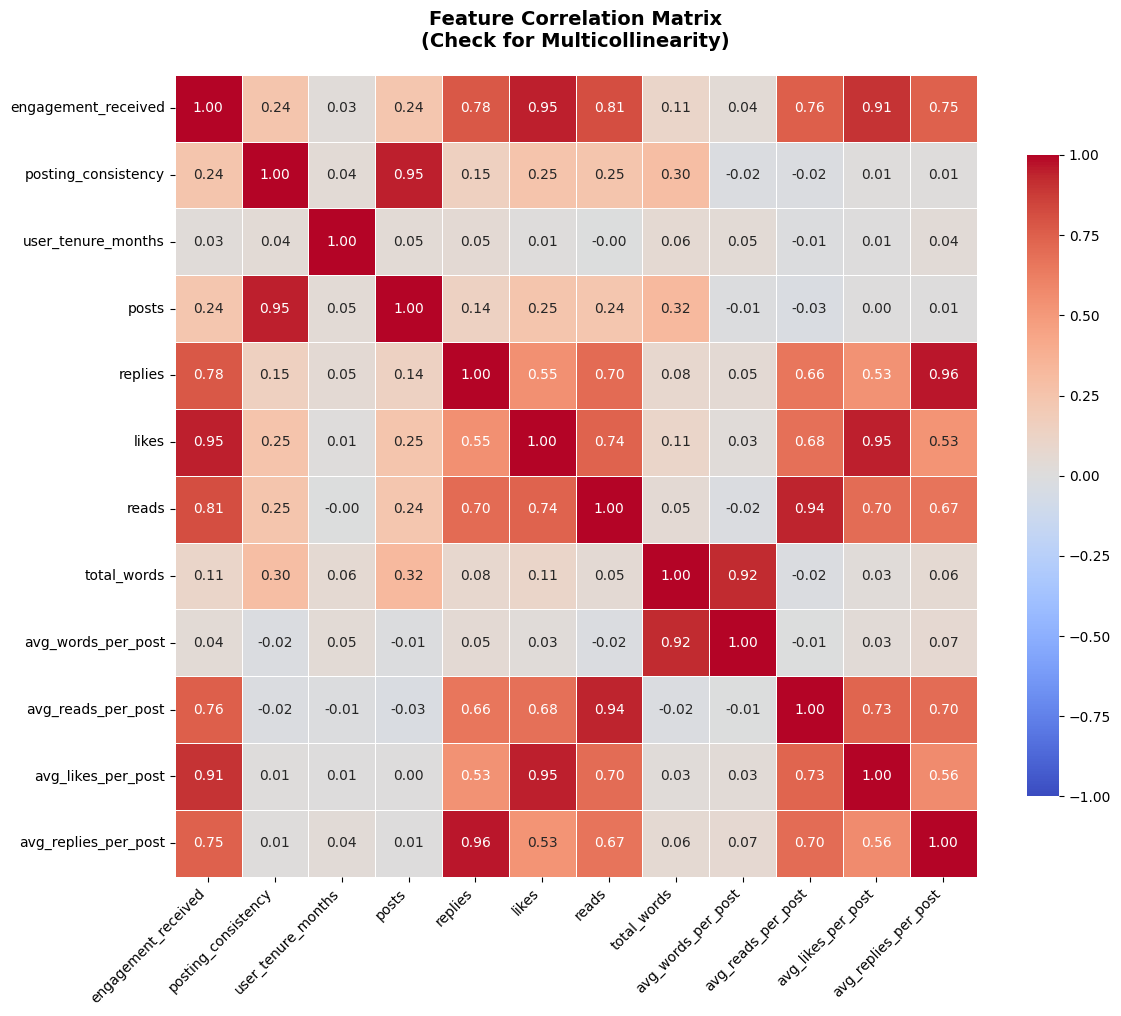

In [27]:
# Calculate correlation matrix
correlation_matrix = X_train[feature_cols].corr()

# Display full correlation matrix
print("\nFull Correlation Matrix:")
# print(correlation_matrix.round(3))

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            vmin=-1, 
            vmax=1)

plt.title('Feature Correlation Matrix\n(Check for Multicollinearity)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
print("\nCorrelation matrix heatmap saved to: correlation_matrix.png")
plt.show()



Train set: 900 samples (863 churned)
Test set: 226 samples (217 churned)

Applying random upsampling...
After upsampling: 1294 samples
Churned: 863 (66.7%)
Retained: 431 (33.3%)

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...

Model training complete

Model Performance:
--------------------------------------------------------------------------------
Logistic Regression       | FN:  39 | FP:   6 | Recall: 0.820 | Precision: 0.967 | F1: 0.888
Random Forest             | FN:  10 | FP:   8 | Recall: 0.954 | Precision: 0.963 | F1: 0.958
Gradient Boosting         | FN:   8 | FP:   8 | Recall: 0.963 | Precision: 0.963 | F1: 0.963
GB (threshold=0.35)       | FN:   5 | FP:   8 | Recall: 0.977 | Precision: 0.964 | F1: 0.970

Best model for minimizing False Negatives: GB (threshold=0.35)

Feature Importance (Random Forest):
  total_words              : 0.1801
  avg_words_per_post       : 0.1387
  reads                    : 0.1327
  user_tenure_months     

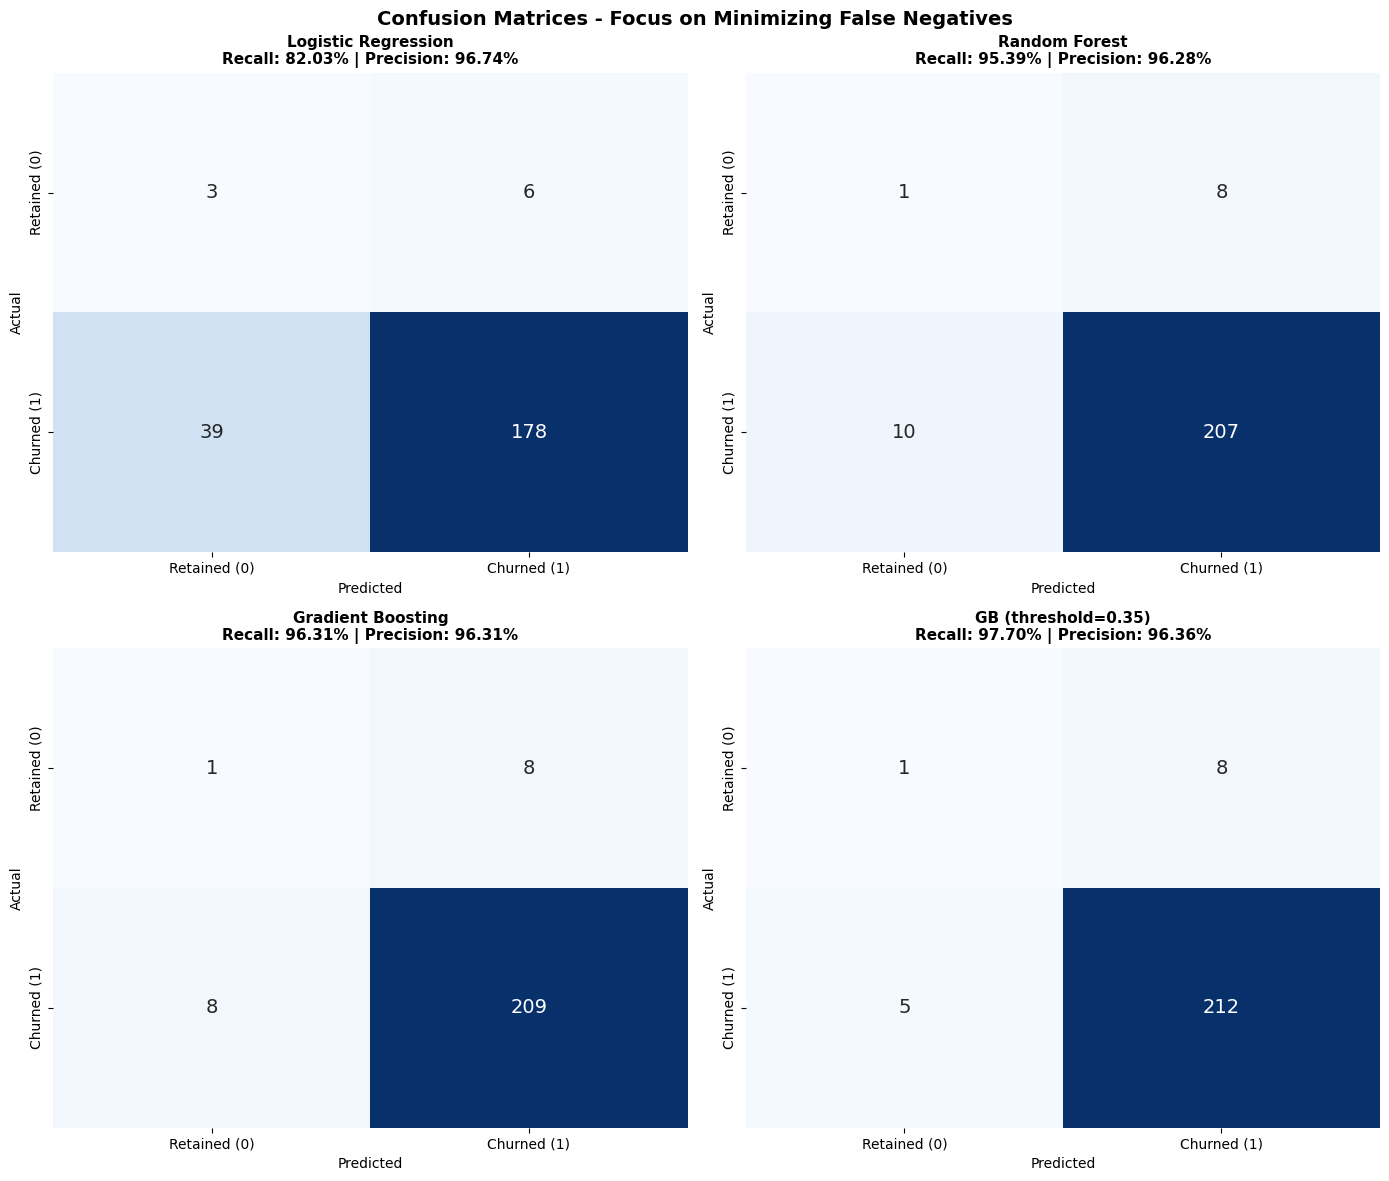

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {len(X_train)} samples ({y_train.sum()} churned)")
print(f"Test set: {len(X_test)} samples ({y_test.sum()} churned)")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random upsampling instead of SMOTE
print("\nApplying random upsampling...")

# Combine features and target for resampling
train_data = pd.DataFrame(X_train_scaled, columns=feature_cols)
train_data['target'] = y_train.values

# Separate majority and minority classes
churned = train_data[train_data['target'] == 1]
retained = train_data[train_data['target'] == 0]

# Upsample minority class (retained) to match majority class (churned)
retained_upsampled = resample(retained,
                              replace=True,
                              n_samples=int((len(churned)-1)/2),
                              random_state=42)

# Combine upsampled minority class with majority class
train_upsampled = pd.concat([churned, retained_upsampled])

# Shuffle the dataset
train_upsampled = train_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Split features and target
X_train_upsampled = train_upsampled[feature_cols].values
y_train_upsampled = train_upsampled['target'].values

print(f"After upsampling: {len(X_train_upsampled)} samples")
print(f"Churned: {y_train_upsampled.sum()} ({y_train_upsampled.mean()*100:.1f}%)")
print(f"Retained: {(len(y_train_upsampled) - y_train_upsampled.sum())} ({(1-y_train_upsampled.mean())*100:.1f}%)")

# Calculate class weights for models that support it
class_weights = {0: y_train.sum()/(len(y_train)-y_train.sum()), 1: 1.0}

# Model 1: Logistic Regression
print("\nTraining Logistic Regression...")
lr = LogisticRegression(class_weight=class_weights, random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Model 2: Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    min_samples_split=20,
    class_weight='balanced', 
    random_state=42, 
    n_jobs=-1
)
rf.fit(X_train_upsampled, y_train_upsampled)
y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Model 3: Gradient Boosting
print("Training Gradient Boosting...")
gb = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_upsampled, y_train_upsampled)
y_pred_gb = gb.predict(X_test_scaled)
y_proba_gb = gb.predict_proba(X_test_scaled)[:, 1]

# Model 4: GB with optimized threshold
threshold = 0.35
y_pred_gb_opt = (y_proba_gb >= threshold).astype(int)

print("\nModel training complete")

# Evaluation
models = [
    ('Logistic Regression', y_pred_lr, y_proba_lr),
    ('Random Forest', y_pred_rf, y_proba_rf),
    ('Gradient Boosting', y_pred_gb, y_proba_gb),
    (f'GB (threshold={threshold})', y_pred_gb_opt, y_proba_gb)
]

print("\nModel Performance:")
print("-" * 80)

results = []
for name, preds, proba in models:
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    roc_auc = roc_auc_score(y_test, proba)
    
    results.append({
        'Model': name,
        'FN': fn,
        'FP': fp,
        'Recall': recall,
        'Precision': precision,
        'F1': f1,
        'ROC-AUC': roc_auc
    })
    
    print(f"{name:25s} | FN: {fn:3d} | FP: {fp:3d} | Recall: {recall:.3f} | Precision: {precision:.3f} | F1: {f1:.3f}")

results_df = pd.DataFrame(results)

# Find model with minimum False Negatives
best_model = results_df.loc[results_df['FN'].idxmin(), 'Model']
print(f"\nBest model for minimizing False Negatives: {best_model}")

# Feature importance from Random Forest
print("\nFeature Importance (Random Forest):")
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in importance_df.iterrows():
    print(f"  {row['feature']:25s}: {row['importance']:.4f}")

# Visualize confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Confusion Matrices - Focus on Minimizing False Negatives', 
             fontsize=14, fontweight='bold')

for idx, (name, preds, proba) in enumerate(models):
    ax = axes[idx // 2, idx % 2]
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Retained (0)', 'Churned (1)'],
                yticklabels=['Retained (0)', 'Churned (1)'],
                cbar=False, annot_kws={'size': 14})
    
    ax.set_title(f'{name}\nRecall: {recall:.2%} | Precision: {precision:.2%}',
                fontsize=11, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=10)
    ax.set_xlabel('Predicted', fontsize=10)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
print("\nConfusion matrices saved to: confusion_matrices.png")
plt.show()

## Test to see if model that drops highly correlated features will have improved performance

Plot shows to keep the original model since model dropping highly correlated features does not see improved performance.

Dropping highly correlated features...
- Removing avg_words_per_post (highly correlated with total_words)
- Removing avg_reads_per_post (highly correlated with reads)

Reduced from 12 to 10 features
Remaining features: ['engagement_received', 'posting_consistency', 'user_tenure_months', 'posts', 'replies', 'likes', 'reads', 'total_words', 'avg_likes_per_post', 'avg_replies_per_post']

Train set: 900 samples (863 churned)
Test set: 226 samples (217 churned)

Applying random upsampling...
After upsampling: 1294 samples
Churned: 863 (66.7%)
Retained: 431 (33.3%)

Training Gradient Boosting with reduced features...

Model Performance with Reduced Features:
--------------------------------------------------------------------------------
GB (reduced features)               | FN:   7 | FP:   8 | Recall: 0.968 | Precision: 0.963 | F1: 0.966
GB (reduced, threshold=0.35)        | FN:   6 | FP:   8 | Recall: 0.972 | Precision: 0.963 | F1: 0.968

COMPARISON: Original vs Reduced Features

Original 

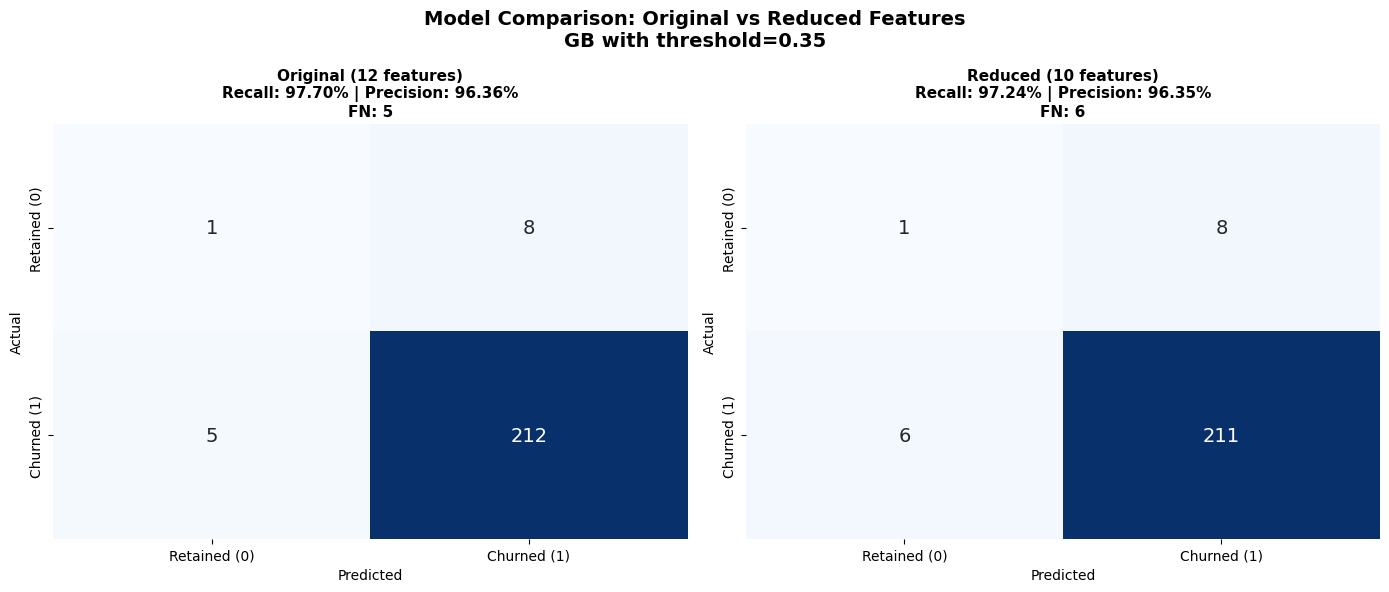

In [29]:
# Drop highly correlated features
print("Dropping highly correlated features...")
print("- Removing avg_words_per_post (highly correlated with total_words)")
print("- Removing avg_reads_per_post (highly correlated with reads)")

# Define reduced feature set
feature_cols_reduced = [
    'engagement_received',
    'posting_consistency',
    'user_tenure_months',
    'posts',
    'replies',
    'likes',
    'reads',
    'total_words',
    # Removed: avg_words_per_post
    # Removed: avg_reads_per_post
    'avg_likes_per_post',
    'avg_replies_per_post'
]

print(f"\nReduced from {len(feature_cols)} to {len(feature_cols_reduced)} features")
print("Remaining features:", feature_cols_reduced)

# Prepare data with reduced features
X_reduced = monthly[feature_cols_reduced]
y_reduced = monthly['churned_next_30d'].astype(int)

# Train-test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reduced, y_reduced, test_size=0.2, random_state=42, stratify=y_reduced
)

print(f"\nTrain set: {len(X_train_r)} samples ({y_train_r.sum()} churned)")
print(f"Test set: {len(X_test_r)} samples ({y_test_r.sum()} churned)")

# Scale features
scaler_r = StandardScaler()
X_train_r_scaled = scaler_r.fit_transform(X_train_r)
X_test_r_scaled = scaler_r.transform(X_test_r)

# Apply random upsampling
print("\nApplying random upsampling...")

train_data_r = pd.DataFrame(X_train_r_scaled, columns=feature_cols_reduced)
train_data_r['target'] = y_train_r.values

churned_r = train_data_r[train_data_r['target'] == 1]
retained_r = train_data_r[train_data_r['target'] == 0]

retained_upsampled_r = resample(retained_r,
                                replace=True,
                                n_samples=int((len(churned_r)-1)/2),
                                random_state=42)

train_upsampled_r = pd.concat([churned_r, retained_upsampled_r])
train_upsampled_r = train_upsampled_r.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_upsampled_r = train_upsampled_r[feature_cols_reduced].values
y_train_upsampled_r = train_upsampled_r['target'].values

print(f"After upsampling: {len(X_train_upsampled_r)} samples")
print(f"Churned: {y_train_upsampled_r.sum()} ({y_train_upsampled_r.mean()*100:.1f}%)")
print(f"Retained: {(len(y_train_upsampled_r) - y_train_upsampled_r.sum())} ({(1-y_train_upsampled_r.mean())*100:.1f}%)")

# Train Gradient Boosting with reduced features
print("\nTraining Gradient Boosting with reduced features...")
gb_reduced = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_reduced.fit(X_train_upsampled_r, y_train_upsampled_r)
y_pred_gb_reduced = gb_reduced.predict(X_test_r_scaled)
y_proba_gb_reduced = gb_reduced.predict_proba(X_test_r_scaled)[:, 1]

# Apply optimized threshold
threshold = 0.35
y_pred_gb_reduced_opt = (y_proba_gb_reduced >= threshold).astype(int)

# Evaluate both models (with and without threshold optimization)
models_reduced = [
    ('GB (reduced features)', y_pred_gb_reduced, y_proba_gb_reduced),
    (f'GB (reduced, threshold={threshold})', y_pred_gb_reduced_opt, y_proba_gb_reduced)
]

print("\nModel Performance with Reduced Features:")
print("-" * 80)

results_reduced = []
for name, preds, proba in models_reduced:
    cm = confusion_matrix(y_test_r, preds)
    tn, fp, fn, tp = cm.ravel()
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    roc_auc = roc_auc_score(y_test_r, proba)
    
    results_reduced.append({
        'Model': name,
        'FN': fn,
        'FP': fp,
        'Recall': recall,
        'Precision': precision,
        'F1': f1,
        'ROC-AUC': roc_auc
    })
    
    print(f"{name:35s} | FN: {fn:3d} | FP: {fp:3d} | Recall: {recall:.3f} | Precision: {precision:.3f} | F1: {f1:.3f}")

results_reduced_df = pd.DataFrame(results_reduced)

# Compare with original model
print("\n" + "=" * 80)
print("COMPARISON: Original vs Reduced Features")
print("=" * 80)

print("\nOriginal Model (12 features):")
print(f"  GB (threshold=0.35) | FN: 5 | Recall: 97.70% | Precision: 96.36%")

print("\nReduced Model (10 features):")
best_reduced = results_reduced_df.loc[results_reduced_df['FN'].idxmin()]
print(f"  {best_reduced['Model']:35s} | FN: {best_reduced['FN']:.0f} | Recall: {best_reduced['Recall']:.2%} | Precision: {best_reduced['Precision']:.2%}")

# Calculate performance change
fn_change = best_reduced['FN'] - 5
recall_change = (best_reduced['Recall'] - 0.9770) * 100

print(f"\nPerformance Change:")
print(f"  False Negatives: {fn_change:+.0f} (fewer is better)")
print(f"  Recall: {recall_change:+.2f} percentage points")

if abs(fn_change) <= 1 and abs(recall_change) <= 2:
    print("\nConclusion: Performance is similar. Reduced model is preferred (simpler with fewer features).")
elif fn_change > 2:
    print("\nConclusion: Performance degraded. Keep original model with all features.")
else:
    print("\nConclusion: Performance improved or maintained. Use reduced model.")

# Feature importance from reduced model
print("\nFeature Importance (Reduced Model):")
importance_reduced = pd.DataFrame({
    'feature': feature_cols_reduced,
    'importance': gb_reduced.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in importance_reduced.iterrows():
    print(f"  {row['feature']:25s}: {row['importance']:.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Model Comparison: Original vs Reduced Features\nGB with threshold=0.35', 
             fontsize=14, fontweight='bold')

# Original model (recreate from your previous results)
original_cm = np.array([[1, 8], [5, 212]])  # From your previous output
reduced_cm = confusion_matrix(y_test_r, y_pred_gb_reduced_opt)

models_to_plot = [
    ('Original (12 features)', original_cm),
    ('Reduced (10 features)', reduced_cm)
]

for idx, (title, cm) in enumerate(models_to_plot):
    ax = axes[idx]
    tn, fp, fn, tp = cm.ravel()
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Retained (0)', 'Churned (1)'],
                yticklabels=['Retained (0)', 'Churned (1)'],
                cbar=False, annot_kws={'size': 14})
    
    ax.set_title(f'{title}\nRecall: {recall:.2%} | Precision: {precision:.2%}\nFN: {fn}',
                fontsize=11, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=10)
    ax.set_xlabel('Predicted', fontsize=10)

plt.tight_layout()
plt.savefig('comparison_reduced_features.png', dpi=300, bbox_inches='tight')
print("\nComparison plot saved to: comparison_reduced_features.png")
plt.show()

## Experiment on GB models with varying probability thresholds (0.3 - 0.5) and varying weight multipliers for the minority class (3 to 5)

Train: 900 (churned=863) | Test: 226 (churned=217)

Grid Results (sorted by fewest FN, then highest Recall, then F1):
                              Run  TN  FP  FN  TP Recall Precision    F1 ROC-AUC
GB(orig) nonchurn_wt x1, thr=0.30   3   6   2 215  0.991     0.973 0.982   0.635
GB(orig) nonchurn_wt x1, thr=0.35   3   6   2 215  0.991     0.973 0.982   0.635
GB(orig) nonchurn_wt x1, thr=0.40   3   6   2 215  0.991     0.973 0.982   0.635
GB(orig) nonchurn_wt x2, thr=0.35   3   6   2 215  0.991     0.973 0.982   0.601
GB(orig) nonchurn_wt x2, thr=0.30   2   7   2 215  0.991     0.968 0.979   0.601
GB(orig) nonchurn_wt x3, thr=0.30   2   7   2 215  0.991     0.968 0.979   0.628
GB(orig) nonchurn_wt x3, thr=0.35   2   7   2 215  0.991     0.968 0.979   0.628
GB(orig) nonchurn_wt x1, thr=0.45   3   6   3 214  0.986     0.973 0.979   0.635
GB(orig) nonchurn_wt x1, thr=0.50   3   6   3 214  0.986     0.973 0.979   0.635
GB(orig) nonchurn_wt x2, thr=0.40   3   6   3 214  0.986     0.973 0.979

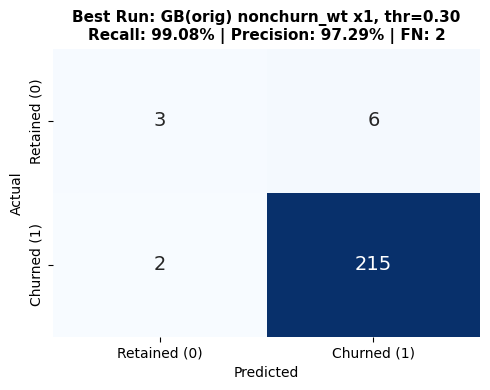

In [32]:
X = monthly[feature_cols].copy()
y = monthly['churned_next_30d'].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print(f"Train: {len(X_train)} (churned={y_train.sum()}) | Test: {len(X_test)} (churned={y_test.sum()})")

# scale (GB doesn't need scaling, but keeping consistent with your pipeline)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# ---------- Grid ----------
weight_multipliers = [1.0, 1.5, 3.0, 4.0, 5.0]              # weight for non-churn (class 0)
thresholds = [0.30, 0.35, 0.40, 0.45, 0.50]

def evaluate_run(name, y_true, y_pred, y_proba):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    recall = tp/(tp+fn) if (tp+fn) else 0.0
    precision = tp/(tp+fp) if (tp+fp) else 0.0
    f1 = (2*precision*recall)/(precision+recall) if (precision+recall) else 0.0
    auc = roc_auc_score(y_true, y_proba)
    return {
        "Run": name, "TN": tn, "FP": fp, "FN": fn, "TP": tp,
        "Recall": recall, "Precision": precision, "F1": f1, "ROC-AUC": auc
    }

results = []

# ---------- Train & Evaluate ----------
for m in weight_multipliers:
    # Upweight NON-CHURN (0) => makes model more conservative about predicting churn
    sample_weight = np.where(y_train.values == 0, m, 1.0)

    gb = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    gb.fit(X_train_sc, y_train.values, sample_weight=sample_weight)
    y_proba = gb.predict_proba(X_test_sc)[:, 1]

    for thr in thresholds:
        y_pred = (y_proba >= thr).astype(int)
        run_name = f"GB(orig) nonchurn_wt x{m:.0f}, thr={thr:.2f}"
        results.append(evaluate_run(run_name, y_test.values, y_pred, y_proba))

results_df = pd.DataFrame(results).sort_values(["FN", "Recall", "F1"], ascending=[True, False, False])
print("\nGrid Results (sorted by fewest FN, then highest Recall, then F1):")
print(results_df.to_string(index=False, formatters={
    "Recall": "{:.3f}".format, "Precision": "{:.3f}".format, "F1": "{:.3f}".format, "ROC-AUC": "{:.3f}".format
}))

# ---------- Pick best run by your priority: minimize False Negatives ----------
best_row = results_df.iloc[0].copy()
print("\nBest configuration:")
print(best_row)

# ---------- Visualize confusion matrix for the best ----------
# retrain best model & re-eval (to fetch CM cleanly)
best_m = float(str(best_row["Run"]).split("x")[1].split(",")[0])
best_thr = float(str(best_row["Run"]).split("thr=")[1])

best_sample_weight = np.where(y_train.values == 0, best_m, 1.0)
gb_best = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
)
gb_best.fit(X_train_sc, y_train.values, sample_weight=best_sample_weight)
y_proba_best = gb_best.predict_proba(X_test_sc)[:, 1]
y_pred_best = (y_proba_best >= best_thr).astype(int)
cm_best = confusion_matrix(y_test.values, y_pred_best)

plt.figure(figsize=(5,4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Retained (0)', 'Churned (1)'],
            yticklabels=['Retained (0)', 'Churned (1)'],
            cbar=False, annot_kws={'size': 14})
plt.title(f'Best Run: {best_row['Run']}\n'
          f'Recall: {best_row["Recall"]:.2%} | Precision: {best_row["Precision"]:.2%} | FN: {int(best_row["FN"])}',
          fontsize=11, fontweight='bold')
plt.ylabel('Actual'); plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('gb_original_features_best_weighted_cm.png', dpi=300, bbox_inches='tight')
plt.show()